In [1]:
from sstcam_simulation.camera.mapping import SSTCameraMapping
from sstcam_simulation.camera.spe import SiPMReflectedOCT
from sstcam_simulation.plotting.image import CameraImage
from sstcam_simulation.io.photoelectron_reader import PhotoelectronReader
from sstcam_simulation import Photoelectrons, Camera, PhotoelectronSource, EventAcquisition
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

0
1
2
3
4


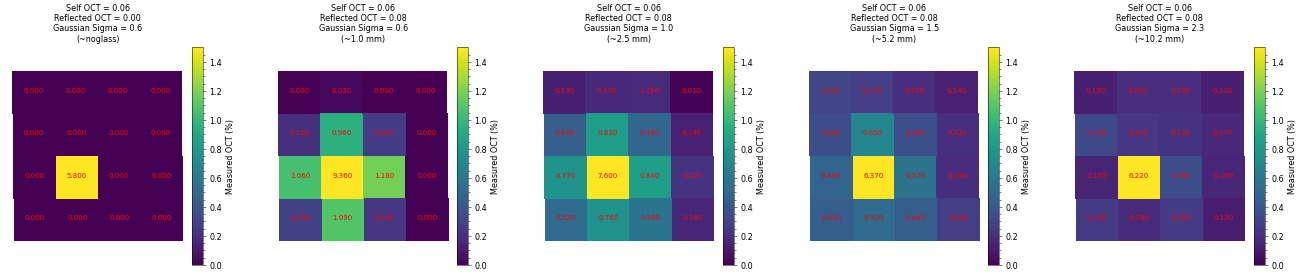

In [3]:
mapping = SSTCameraMapping(n_pixels=16)
spectra = {
    'noglass': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0, reflected_scale=0.6, mapping=mapping, normalise_charge=False),
    '1.0 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=0.6, mapping=mapping, normalise_charge=False),
    '2.5 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=1.0, mapping=mapping, normalise_charge=False),
    '5.2 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=1.5, mapping=mapping, normalise_charge=False),
    '10.2 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=2.3, mapping=mapping, normalise_charge=False),
}

fig = plt.figure(figsize=(23, 4))

ipix = 2
n_events = 10000

for i, (key, photoelectron_spectrum) in enumerate(spectra.items()):
    print(i)
    ax = fig.add_subplot(1, len(spectra), i+1)

    camera = Camera(
        photoelectron_spectrum=photoelectron_spectrum,
    )
    source = PhotoelectronSource(camera=camera)

    images = np.zeros((n_events, mapping.n_pixels))
    pe = Photoelectrons(time=np.array([10]), pixel=np.array([ipix]), charge=np.array([1]))
    for i in range(n_events):
        pe_resampled = source.resample_photoelectron_charge(pe)
        image = pe_resampled.get_charge_per_pixel(mapping.n_pixels)
        images[i] = image

    images[:, ipix] -= 1
    measured_opct = (images > 0.5).sum(0) / n_events * 100

    ci = CameraImage.from_coordinates(mapping.pixel, ax=ax)
    ci.image = measured_opct
    text = np.array([f"{v:.3f}" for v in ci.image])
    ci.add_pixel_text(text, size=7, color='red')
    ci.add_colorbar("Measured OCT (%)", pad=0)
    ci.set_limits_minmax(0, 1.5)
    ax.set_title(f"Self OCT = {photoelectron_spectrum.opct:.2f}\nReflected OCT = {photoelectron_spectrum.reflected_opct:.2f}\nGaussian Sigma = {photoelectron_spectrum.reflected_scale:.1f}\n(~{key})")
    
fig.savefig("NN_OCT_dark_counts.pdf")

0
1
2
3
4


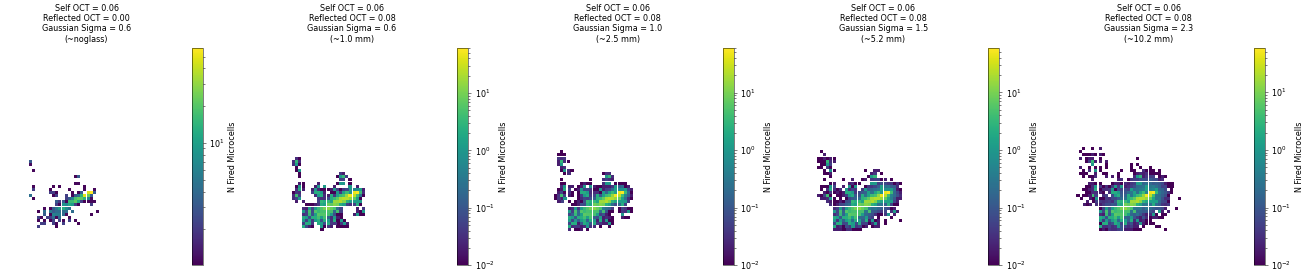

In [4]:
mapping = SSTCameraMapping()
spectra = {
    'noglass': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0, reflected_scale=0.6, mapping=mapping, normalise_charge=False),
    '1.0 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=0.6, mapping=mapping, normalise_charge=False),
    '2.5 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=1.0, mapping=mapping, normalise_charge=False),
    '5.2 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=1.5, mapping=mapping, normalise_charge=False),
    '10.2 mm': SiPMReflectedOCT(spe_sigma=0, opct=0.06, reflected_opct=0.08, reflected_scale=2.3, mapping=mapping, normalise_charge=False),
}

path = "/Users/Jason/Software/sstcam-simulation/sstcam_simulation/data/cherenkov/gamma.h5"
reader = PhotoelectronReader(path)
pe = reader[47]
n_events = 100

fig = plt.figure(figsize=(23, 4))
for i, (key, photoelectron_spectrum) in enumerate(spectra.items()):
    print(i)
    ax = fig.add_subplot(1, len(spectra), i+1)

    camera = Camera(
        photoelectron_spectrum=photoelectron_spectrum,
    )
    source = PhotoelectronSource(camera=camera)
    
    images = np.zeros((n_events, mapping.n_pixels))
    for i in range(n_events):
        pe_resampled = source.resample_photoelectron_charge(pe)
        image = pe_resampled.get_charge_per_pixel(mapping.n_pixels)
        images[i] = image
    avg = images.mean(0)

    ci = CameraImage.from_coordinates(mapping.pixel, ax=ax)
    ci.image = avg
    ci.add_colorbar("N Fired Microcells", pad=0.1)
#     ci.set_limits_minmax(0, 5)
    ci.set_z_log()
    ax.set_title(f"Self OCT = {photoelectron_spectrum.opct:.2f}\nReflected OCT = {photoelectron_spectrum.reflected_opct:.2f}\nGaussian Sigma = {photoelectron_spectrum.reflected_scale:.1f}\n(~{key})")
    
fig.savefig("NN_OCT_shower_example.pdf")